# DNN: analyse data with Keras 

## Structure of the report

**0. Abstract (Conclusions are required to complete it, while the abstract introduction is ready)**

**1. Introduction**: what are the goals of our study, which tools we use (DNN with Keras, CV), how we test performances (quick explanation of training and test set), how we plan to improve the performances (data augmentation, 4-Fold CV)

**2. Methods**: how training data are generated (1st and/or 2nd nonlinear functions), how training data is augmented (eventually with code snippets), definition of functions and parameters used in the CV procedure, (??rescaling function implied??)

**3. Results**: Plot of accuracies+classification for the starting DNN, accuracies varying the number (and the type) of training samples, best model of DNN after CV and plot results w.r.t. starting DNN

**4. Conclusions**: how augmenting data affects the performances, whether the CV procedure is worth to be implemented or it requires too much effort for a small gain in performances, role of each hyperparameters in the overall result, (??performaces w.r.t. rescaling??), dependence on type of function, **outlook** to further improve our model

## Structure of the data analysis

**1.** Presentation of the two non-linear functions, plot of input data for both functions

--- Study of the 1st nonlinear function ---

**2.** Presentation of the base model with architecture (<u>2</u>, 2, 20, 20, <u>2</u>) applied to the 1st function: {training and test 'errors', graphical results for the prediction}

**3.** Grid search over the parameter space to find an optimized model focusing only on architecture size applied to the 1st function: {training and test 'errors', graphical results for the prediction, confusion matrix}

**4.** History plots on the same axe of both architectures: accuracy+loss

**5.** History plots for the modified architecture for different values of N = {2000, 4000, 6000, 4000+augment}. Explanation of the motivation behind those 'errors' evolution. 

--- Study of the 2nd nonlinear function ---

**6.** Presentation of the base model with a "normal" architecture like (<u>2</u>, 20, 20, 20, <u>2</u>) applied to the 2nd function: {training and test 'errors', graphical results for the prediction}

**7.** Grid search over the parameter space to find an optimized model (at first architecture improvements and then fine tuning), presentation of results: {training and test 'errors', graphical results for the prediction, confusion matrix}

**8.** [Quick] Study of rescaling of data and different initilaizations


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools

# DNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Input, optimizers, initializers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as opt
from keras.constraints import maxnorm
from sklearn.preprocessing import RobustScaler

# plot
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from matplotlib.ticker import MultipleLocator
# plt.reParams['font.size'] = 14
import seaborn as sns

%run nonlinear_function.py

# training data
perc_train = 0.8

# data augmentation
augment_data = False
aug_amount = 3200


# save training data (loss, accuracy) in a csv file
save_csv = False

## Definitions 

In [2]:
def Rescale(x, res_type = 0, **kwargs):
    # TYPES
    # 0 --> absolute maximum (requires scale)
    # 1 --> min max (requires xmax, xmin)
    # 2 --> normalization (requires xmean, xmax, xmin)
    # 3 --> standardization (requires xmean, xvar)
    # 4 --> robust scaling thorugh scikit-learn

    if res_type==0:

        if 'scale' in kwargs:
            scale = kwargs['scale']
        else: # default
            return x
        
        return x/scale

    elif res_type==1:
        
        if 'xmax' in kwargs and 'xmin' in kwargs:
            xmax, xmin = kwargs['xmax'], kwargs['xmin']
        else: # default
            return 0
        
        return (x-xmin)/(xmax-xmin)  
        
    elif res_type==2:
        
        if 'xmax' in kwargs and 'xmin' in kwargs and 'xmean' in kwargs:
            xmean, xmax, xmin = kwargs['xmean'], kwargs['xmax'], kwargs['xmin']
        else: # default
            return 0
        
        return (x-xmean)/(xmax-xmin)
        
    elif res_type==3:
        
        if 'xmean' in kwargs and 'xvar' in kwargs:
            xmean, xvar = kwargs['xmean'], kwargs['xvar']
        else: # default
            return 0
        
        return (x-xmean)/np.sqrt(xvar)
        
    elif res_type==4:
        transformer = RobustScaler().fit(x)
        return transformer.transform(x) 
    else: # default
        return 0

In [3]:
# compile a specified model with a particular optimizer
# useful for GridSearchCV
def compile_model(activation, dropout, layer_size, weight_constraint,
                  opt_name, learn_rate, momentum):

    # create the model
    model = Sequential()

    # add architecture specs
    # first layer: SPECIFIED EXPLICITLY
    model.add(Input(shape=(L,)))

    # hidden layers
    for lyr_sz in layer_size:
        model.add(Dense(lyr_sz, activation=activation, kernel_constraint=maxnorm(weight_constraint)))

    # dropout rate
    model.add(Dropout(dropout))

    # output layer
    model.add(Dense(num_classes, activation='sigmoid'))

    
    # define optimizer
    if opt_name == 'Adam':
        optimizer = opt.Adam(learning_rate=learn_rate)
    elif opt_name == 'RMSprop':
        optimizer = opt.RMSprop(learning_rate=learn_rate, momentum=momentum)
    elif opt_name == 'SGD':
        optimizer = opt.SGD(learning_rate=learn_rate, momentum=momentum, nesterov=False)
    elif opt_name == 'Nesterov':
        optimizer = opt.SGD(learning_rate=learn_rate, momentum=momentum, nesterov=True)
    else:
        optimizer = None


    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])


    return model

# First non-linear function

## Preprocessing

#### Visualization of 2D input data

L = 2

[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 1.0

data: 4000


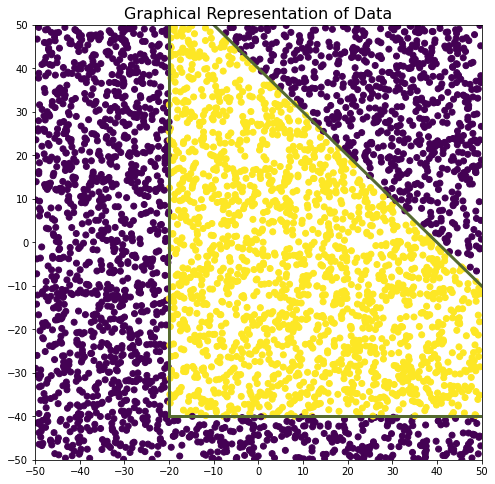

In [4]:
# Keras works with numpy arrays: just use them from the start
TYPE = 1
x = np.loadtxt(filename("data", TYPE), delimiter=' ')
y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
N = len(x)

# dim of a sample
L = len(x[0])
print('L =', L)

print('')
for i in range(10):
    print(x[i], y[i])

print(f'\ndata: {N}')

def boundaries():    
    ax.plot((-20,-20),(-40,50),c="darkolivegreen", linewidth=3)
    ax.plot((-20,50),(-40,-40),c="darkolivegreen", linewidth=3)
    ax.plot((-10,50),(50,-10),c="darkolivegreen", linewidth=3)

# plot data with colormap
fig,ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x[:,0], x[:,1], c=y)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
#plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1'],
 #       title="Classes", loc='center left', 
  #      bbox_to_anchor=(1, 0.5), fontsize=14
       # )
boundaries()

ax.set_title("Graphical Representation of Data",fontsize=16)

plt.savefig("Graph_Data_Nlin1", bbox_inches="tight")

plt.show()

#### Splitting data into training and test data

In [5]:
N_train = int(perc_train * N)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]
print('Train:', len(x_train), '\t Validation:', len(x_valid))

Train: 3200 	 Validation: 800


#### Rescale input data

In [6]:
x_train = Rescale(x_train, scale=50)
x_valid = Rescale(x_valid, scale=50)

#### Data augmentation
Obviously, only the training data are augmented, while the validation set remains unchanged.

In [7]:
if augment_data:

    # generate random shifts for the selected training data
    theta = np.random.rand(aug_amount)*(2*np.pi) # random directions of shifts
    mask = np.random.choice(x_train.shape[0], aug_amount, replace=True)
    shift = np.random.normal(loc=0.1, scale=0.01, size=aug_amount)
    shift[abs(shift-0.1)>0.2]=0.1 #To avoid outliers
    # augmented data are shifted w.r.t. the original data
    # and have the same label
    x_aug = x_train[mask] +  np.vstack((shift*np.cos(theta),shift* np.sin(theta))).T
    y_aug = y_train[mask]

    # training data are increased
    x_train = np.vstack((x_train, x_aug))
    y_train = np.hstack((y_train, y_aug))

    print('training data:', x_train.shape[0])


In [8]:
# Switching to one-hot encoding
num_classes = 2
y_train =tf.keras.utils.to_categorical(y_train, num_classes)
y_valid =tf.keras.utils.to_categorical(y_valid, num_classes)

## Base model with Keras

In [9]:
# reproducibility
np.random.seed(12345) # maybe not useful (Keras has is own initialization..)

# sequential model
model=Sequential()
model.add(Input(shape=(L,)))
model.add(Dense(2, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='sigmoid'))
nepoch=400
batch_size=50


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 528
Trainable params: 528
Non-trainable params: 0
_________________________________________________________________


### Optimization method and cost function

In [10]:
model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

### Training

In [11]:
fit = model.fit(x_train, y_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x_valid, y_valid), 
                verbose=0)

In [12]:
eval_train = model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
eval_test = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)

print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1])

Training loss: 0.1630
Test loss: 0.1581
Training accuracy: 0.9250
Test accuracy: 0.9287


### Saving history of training in a .csv file

In [13]:
if save_csv: 
    import csv

    training_data = np.column_stack((fit.history['accuracy'], fit.history['val_accuracy'], fit.history['loss'], fit.history['val_loss']))

    if augment_data: 
        filename = 'TrainingHistory/training_Augmented_'+str(aug_amount)+'.csv'
    else:
        filename = 'TrainingHistory/training_'+str(N)+'.csv'
    header = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(header)
        writer.writerows(training_data)


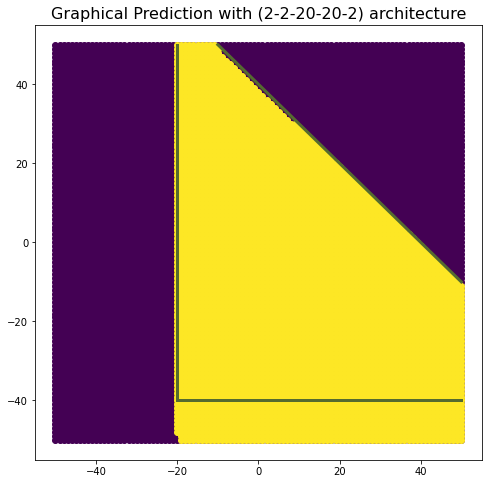

In [14]:
dX = 1
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1


# Rescale grid with the same rescaling function
grid_r = Rescale(grid, scale=50)

# predict labels on the grid
pred = model.predict(grid_r)


#fig,AX = plt.subplots(1,3,figsize=(16,5.))

fig,ax = plt.subplots(1,figsize=(8,8))

#ax=AX[0]
#ax.scatter(x[:,0],x[:,1], c=y)
#boundaries()

#ax=AX[1]
#ax.scatter(grid[:,0],grid[:,1],c=pred[:,1])
#boundaries()

#ax=AX[2]
W1=np.where(pred[:,1]>0.5)[0]
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()


ax.set_title("Graphical Prediction with (2-2-20-20-2) architecture", fontsize=16)


plt.savefig("Graph_Pred_Nlin1_Model", bbox_inches="tight")

plt.show()

In [ ]:
# model for the second architecture
model_3=Sequential()
model_3.add(Input(shape=(L,)))
model_3.add(Dense(3, activation='relu'))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(num_classes, activation='sigmoid'))
nepoch=400
batch_size=50

    
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 20)                80        
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 42        
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['accuracy'])

In [ ]:
fit_3 = model_3.fit(x_train, y_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x_valid, y_valid), 
                verbose=0)

KeyboardInterrupt: 

In [ ]:
eval_3_train = model_3.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
eval_3_test = model_3.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)

print('Training loss: %.4f' % eval_3_train[0])
print('Test loss: %.4f' % eval_3_test[0])
print('Training accuracy: %.4f' % eval_3_train[1])
print('Test accuracy: %.4f' % eval_3_test[1])

Training loss: 0.0817
Test loss: 0.0914
Training inaccuracy: 0.0072
Test inaccuracy: 0.0025


In [ ]:
pred_3 = model_3.predict(grid_r)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

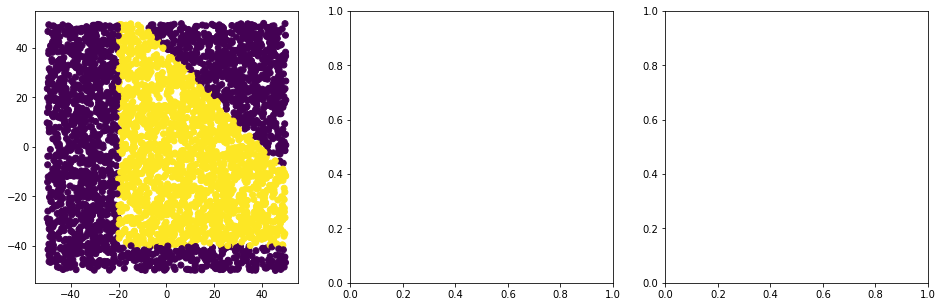

In [ ]:
fig,ax = plt.subplots(1,figsize=(8, 8))


W1=np.where(pred_3[:,1]>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")

ax.set_title("Graphical Prediction with (2-3-20-20-2) architecture", fontsize=16)

plt.savefig("Graph_Pred_Nlin1_Model_3", bbox_inches="tight")

plt.show()

### History plots for different training sets (different N)
In order to obtain the file used below we have run several times the code above by setting to True the variable `save_csv` and by changing the variables `N` and `augment_data`. At the end we obtained a folder named "TrainingHistory" with the histories of all the losses and accuracies for each choice of the mentioned variables. On the [GitHub page](https://github.com/tommasoamico/ComputationalPhysics_modB/tree/main/ASSIGNMENT) of the assignment it is possible to see the folder with all the data. The two cells below suppose the presence of such folder in the same location of this notebook.

In [ ]:
folder_name = 'TrainingHistory'
file_names = ['training_2000.csv', 'training_4000.csv', 'training_6000.csv', 'training_Augmented_3200.csv']
file_paths = [folder_name+"/"+name for name in file_names]

df_dic={'N='+path[len(folder_name)+10:-4]: pd.read_csv(path) for path in file_paths[:-1]}
df_dic[f'Data augmentation']= pd.read_csv(file_paths[-1])
    
print('Dataframes available: ', [i for i in df_dic.keys()])

Dataframes available:  ['N=2000', 'N=4000', 'N=6000', 'Data augmentation']


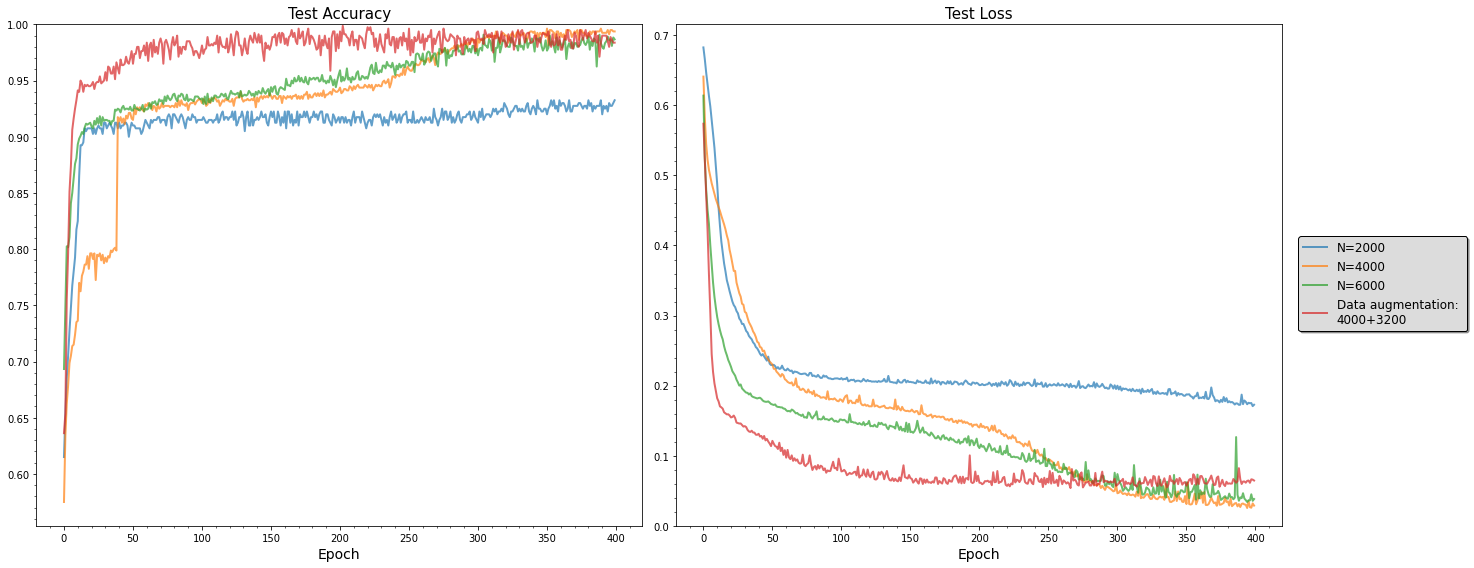

In [ ]:
fig, AX = plt.subplots(1,2,figsize=(18,8))

# no data augmentation
for key in itertools.islice(df_dic.keys(), 3):
    AX[0].plot(df_dic[key]['val_accuracy'], label=key, linewidth=2, alpha=0.7)
    AX[1].plot(df_dic[key]['val_loss'], label=key, linewidth=2, alpha=0.7)

# data augmentation
AX[0].plot(df_dic[list(df_dic.keys())[-1]]['val_accuracy'], label=f"Data augmentation: \n4000+3200", linewidth=2, alpha=0.7)
AX[1].plot(df_dic[list(df_dic.keys())[-1]]['val_loss'], label=f"Data augmentation: \n4000+3200", linewidth=2, alpha=0.7)

# plot options
AX[0].minorticks_on()
AX[0].set_title("Test Accuracy", fontsize=15)
AX[0].set_ylim(top=1)
AX[0].set_xlabel("Epoch", fontsize=14)
# AX[0].legend(loc="lower right", fontsize=10)

AX[1].minorticks_on()
AX[1].set_title("Test Loss", fontsize=15)
AX[1].set_ylim(bottom=0)
AX[1].set_xlabel("Epoch", fontsize=14)
# AX[1].legend(loc="upper right", fontsize=10)

axLines, axLabels = AX[0].get_legend_handles_labels()
 
fig.legend(axLines, axLabels, 
    loc='center left', bbox_to_anchor=(1, 0.5), 
    fontsize=14, prop={'size':14}, facecolor='gainsboro', edgecolor='black', shadow=True
    )


plt.savefig("Test_AccuracyAndLoss", bbox_inches="tight")


fig.tight_layout()
plt.show()


## Improving the base model with Grid Search

In [ ]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=0)


# list of allowed optional arguments for the optimizer
optimizer = ['Adam', 'RMSprop']
activation = ['sigmoid', 'relu']
layer_size = [(3, 20, 20,), (10,10,5,), (50,50,)]

# define parameter dictionary
param_grid = {'activation': activation,
              'layer_size': layer_size,            
              'opt_name': optimizer,
              'learn_rate':[0.001],
              'momentum':[0.0]
              }

<ipython-input-21-c42ae2a82593>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model,


### Perform Grid Search CV

In [ ]:
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

### Grid Search CV results

In [ ]:
# summarize results

results_df = pd.DataFrame(grid.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
print(grid_result.best_params_)

print("\nScore with best parameters:")
print(grid_result.best_score_)

**Let's try to find meaningful data into CV folds...**

In [ ]:
def cv_plot(cv_results, figsize, leg_size, folds):
    results_df = pd.DataFrame(cv_results).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
    x_axis=np.arange(1, folds+1)
    model_scores = results_df.filter(regex=r"split\d*_test_score")
    color_list= sns.color_palette("inferno", 20).as_hex()[::4]
    
    # plot 30 examples of dependency between cv fold and AUC scores
    fig, ax = plt.subplots(figsize=figsize)
    for item, color in zip(range(0,24), color_list):
        ax.plot(x_axis, model_scores.iloc[item,:], alpha=0.5, color = color, label=results_df['params'][item], linewidth=2.5)
        ax.scatter(x_axis, model_scores.iloc[item,:], alpha=0.8, color = color, s=50, edgecolor='black')
    
    ax.set_xlabel("CV test fold", size=16, labelpad=10)
    ax.set_ylabel("Test scores", size=16)
    ax.set_xticks(ticks=x_axis)
    ax.legend(shadow=True, framealpha=1, facecolor='white', edgecolor='black', title='model', title_fontsize='xx-large', prop={'weight':'bold','size':leg_size}, loc=(1.01,0), labelcolor='linecolor', markerscale=2)
    ax.minorticks_on()
    ax.set_title('Cross validation performance', fontsize=20)

    plt.show()
    return fig, ax

cv_plot(cv_results=grid.cv_results_, figsize=(8,8), leg_size=12, folds=4)



### Results of the improved model 

In [ ]:
# best model from CV
best_params = grid_result.best_params_

best_model = compile_model(activation = best_params['activation'],
                           dropout = best_params['dropout'],
                           layer_size = best_params['layer_size'],
                           weight_constraint = best_params['weight_constraint'],
                           opt_name = best_params['opt_name'],
                           learn_rate = best_params['learn_rate'],
                           momentum = best_params['momentum']
                          )

print(best_model.summary())

In [ ]:
# at the end train the best model using the full training set
fit_best = best_model.fit(x_train, y_train, 
                epochs = best_params['epochs'],
                batch_size=batch_size, 
                validation_data=(x_valid, y_valid), 
                verbose=0)

In [ ]:
# show errors
eval_train = best_model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0)
eval_test = best_model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=0)

print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1])

### History plots of train and test performances

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(fit.history['accuracy'], color='C0', alpha=0.8)
ax.plot(fit.history['val_accuracy'], color='C1', alpha=0.8)


ax.plot(fit_best.history['accuracy'], color='C2', alpha=0.8)
ax.plot(fit_best.history['val_accuracy'], color='C3', alpha=0.8)


ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_title("Accuracy history", fontsize=16)
ax.set_ylim(top=1.0)
ax.minorticks_on()




ax=AX[1]
ax.plot(fit.history['loss'],label="Train", color='C0', alpha=0.8)
ax.plot(fit.history['val_loss'],label="Valid", color='C1', alpha=0.8)

ax.plot(fit_best.history['loss'],label="Train", color='C3', alpha=0.8)
ax.plot(fit_best.history['val_loss'],label="Valid", color='C3', alpha=0.8)

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.set_title("Loss history", fontsize=16)
ax.set_ylim(bottom=0.0)
ax.minorticks_on()


ax.legend(loc="upper right", fontsize=14)

fig.tight_layout()


## Confusion Matrix

# Study of another non-linear function - 2

L = 2

data: 4000


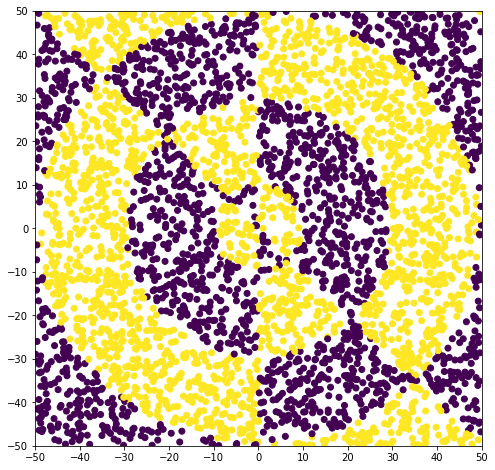

In [ ]:
TYPE = 2
x2 = np.loadtxt(filename("data", TYPE), delimiter=' ')
y2 = np.loadtxt(filename("labels", TYPE), delimiter=' ')
N_2 = len(x2)

# dim of a sample
L_2 = len(x2[0])
print('L =', L_2)

print(f'\ndata: {N_2}')


# plot data with colormap
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x2[:,0], x2[:,1], c=y2)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))


plt.savefig("Graph_Data_Nlin2", bbox_inches="tight")


plt.show()

In [ ]:
N2_train = int(perc_train * N_2)   #maintain the same perc = 0.8

x2_train, y2_train = x2[0:N2_train], y2[0:N2_train]
x2_valid, y2_valid = x2[N2_train:], y2[N2_train:]
print('Train:', len(x2_train), '\t Validation:', len(x2_valid))


# Rescaling data using the same rescaling function
x2_train = Rescale(x2_train, scale=50)
x2_valid = Rescale(x2_valid, scale=50)


Train: 3200 	 Validation: 800


In [ ]:
# Switching to one-hot encoding 
num_classes = 2
y2_train =tf.keras.utils.to_categorical(y2_train, num_classes)
y2_valid =tf.keras.utils.to_categorical(y2_valid, num_classes)

In [ ]:
#Defining the first architecture

# sequential model
model=Sequential()
model.add(Input(shape=(L,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='sigmoid'))
nepoch=400
batch_size=50


model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', 
                optimizer='Adam', 
                metrics=['accuracy'])

In [ ]:
fit_2 = model.fit(x2_train, y2_train, 
                epochs = nepoch,
                batch_size=batch_size, 
                validation_data=(x2_valid, y2_valid), 
                verbose=0)

In [ ]:
# show errors
eval_train = model.evaluate(x2_train, y2_train, batch_size=batch_size, verbose=0)
eval_test = model.evaluate(x2_valid, y2_valid, batch_size=batch_size, verbose=0)

print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1]))

Training loss: 0.1854
Test loss: 0.3315
Training inaccuracy: 0.0591
Test inaccuracy: 0.0888


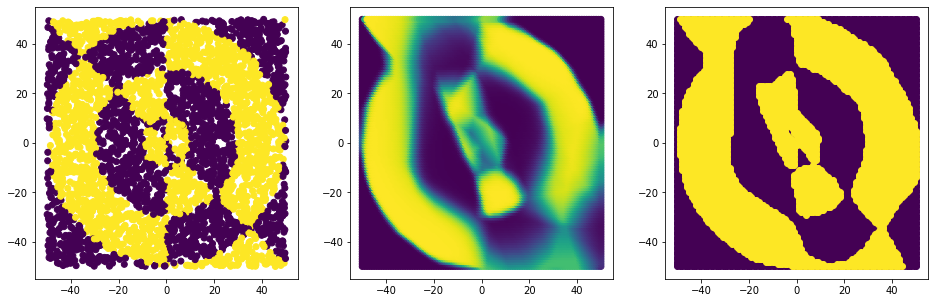

In [ ]:
dX = 1
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid2 = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid2[k,:]=(X1[j],X1[i])
        k=k+1


# RESCALE maintaining the same grid [-50,50]x[-50,50]
grid2_r = Rescale(grid2, scale=50)

pred_2 = model.predict(grid2_r)


fig,AX = plt.subplots(1,3,figsize=(16,5.))

ax=AX[0]
ax.scatter(x2[:,0],x2[:,1], c=y2)


ax=AX[1]
ax.scatter(grid2[:,0],grid2[:,1],c=pred_2[:,1])


ax=AX[2]
W1=np.where(pred_2[:,1]>0.5)[0] 
ax.scatter(grid2[:,0],grid2[:,1],c="#440154")
ax.scatter(grid2[W1,0],grid2[W1,1],c="#fde725")


ax.set_title("Graphical Prediction with (2-20-20-20-2) architecture", fontsize=16)

plt.savefig("Graph_Pred_Nlin2_Model", bbox_inches="tight")


plt.show()

### 4 hours MIN Hardcore CV to improve the performances

In [ ]:
# call Keras scikit wrapper
model2_gridsearch = KerasClassifier(build_fn=compile_model,
                                            epochs=1,
                                            batch_size=batch_size,
                                            verbose=0)

optimizer = ['Adam', 'RMSprop', 'Nesterov']
activation = ['sigmoid', 'relu', 'elu', 'tanh']
dropout = [0.05, 0.25, 0.5]
layer_size = [(50,50,), (20, 20, 20,), (30, 30, 30), (10, 10, 10, 10,)]
weight_constraint = [1, 2, 3, 4]


# define parameter dictionary
param_grid2 = {'activation': activation,
              'dropout': dropout,
              'layer_size': layer_size,            
              'weight_constraint': weight_constraint,
              'opt_name': optimizer,
              'learn_rate':[0.001],
              'momentum':[0.0]
              }


<ipython-input-50-1d9c4f5dd5a0>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model2_gridsearch_FineTune = KerasClassifier(build_fn=compile_model,


In [ ]:
# call scikit grid search module
grid2 = GridSearchCV(estimator=model2_gridsearch,
                                 param_grid=param_grid2,
                                 n_jobs=1,
                                 cv=4)
grid2_result = grid2.fit(x2_train,y2_train)

In [ ]:
# summarize results
results_df = pd.DataFrame(grid2_result.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid2.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
print(grid2_result.best_params_)

print("\nScore with best parameters:")
print(grid2_result.best_score_)

,param_activation,param_dropout,param_layer_size,param_weight_constraint,param_opt_name,param_learn_rate,param_momentum,param_epochs,mean_test_score,rank_test_score
0,relu,0.05,"(20, 20, 20, 20, 20)",4,RMSprop,0.001,0.0,200,0.955938,1
1,relu,0.05,"(34, 33, 33)",4,RMSprop,0.001,0.0,200,0.951875,2
2,relu,0.05,"(25, 25, 25, 25)",4,RMSprop,0.001,0.0,200,0.951875,2
3,relu,0.05,"(17, 17, 17, 17, 16, 16)",4,RMSprop,0.001,0.0,200,0.939688,4
4,relu,0.05,"(15, 15, 14, 14, 14, 14, 14)",4,RMSprop,0.001,0.0,200,0.930625,5
5,relu,0.05,"(50, 50)",4,RMSprop,0.001,0.0,200,0.929688,6




Best parameters set found:
{'activation': 'relu', 'dropout': 0.05, 'epochs': 200, 'layer_size': (20, 20, 20, 20, 20), 'learn_rate': 0.001, 'momentum': 0.0, 'opt_name': 'RMSprop', 'weight_constraint': 4}

Score with best parameters:
0.9559375047683716


### Fine Tuning of optimizer parameters (learning rate, momentum, epochs)
We set the best optimizer from the previous CV and we perform another CV to fine tune the optimizer parameters

In [ ]:
# call Keras scikit wrapper
model2_gridsearch_FineTune = KerasClassifier(build_fn=compile_model,
                                            epochs=1,
                                            batch_size=batch_size,
                                            verbose=0)


# list of allowed optional arguments for the optimizer
epochs = [100, 200, 400]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.5, 0.9]


# define parameter dictionary
param_grid2_FineTune = { 'activation': [grid2_result.best_params_['activation']],
                        'dropout': [grid2_result.best_params_['dropout']],
                        'layer_size': [grid2_result.best_params_['layer_size']],            
                        'weight_constraint': [grid2_result.best_params_['weight_constraint']],
                        'opt_name': [grid2_result.best_params_['opt_name']],
                        'learn_rate': learn_rate,
                        'momentum': momentum,
                        'epochs': epochs
                        }

<ipython-input-24-75a03d87bd3d>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch_FineTune = KerasClassifier(build_fn=compile_model,


In [ ]:
# call scikit grid search module
grid_FineTune = GridSearchCV(estimator=model2_gridsearch_FineTune,
                                 param_grid=param_grid2_FineTune,
                                 n_jobs=1,
                                 cv=4)

grid_result_FineTune = grid_FineTune.fit(x2_train,y2_train)

In [ ]:
# summarize results
results_df = pd.DataFrame(grid_FineTune.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid2_FineTune.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
print(grid_result_FineTune.best_params_)

print("\nScore with best parameters:")
print(grid_result_FineTune.best_score_)

,param_activation,param_dropout,param_layer_size,param_weight_constraint,param_opt_name,param_learn_rate,param_momentum,param_epochs,mean_test_score,rank_test_score
0,relu,0.05,"(20, 20)",1,Adam,0.001,0.0,100,0.990313,1




Best parameters set found:
{'activation': 'relu', 'dropout': 0.05, 'epochs': 100, 'layer_size': (20, 20), 'learn_rate': 0.001, 'momentum': 0.0, 'opt_name': 'Adam', 'weight_constraint': 1}

Score with best parameters:
0.9903125017881393


In [ ]:
cv_plot(cv_results=grid_result_FineTune.cv_results_, figsize=(12,12), leg_size=18, folds=4)

In [ ]:
# best model from CV
best_params = grid_result_FineTune.best_params_

best_model = compile_model(activation = best_params['activation'],
                           dropout = best_params['dropout'],
                           layer_size = best_params['layer_size'],
                           weight_constraint = best_params['weight_constraint'],
                           opt_name = best_params['opt_name'],
                           learn_rate = best_params['learn_rate'],
                           momentum = best_params['momentum']
                          )


best_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 20)                60        
                                                                 
 dense_34 (Dense)            (None, 20)                420       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                 42        
                                                                 
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________
None


### Results of the fine-tuned model

In [ ]:
# at the end train the best model using the full training set

fit_best = best_model.fit(x2_train, y2_train, 
                epochs = grid_result_FineTune.best_params_['epochs'],
                batch_size=batch_size, 
                validation_data=(x2_valid, y2_valid), 
                verbose=0)

In [ ]:
# show errors
eval_train = best_model.evaluate(x2_train, y2_train, batch_size=batch_size, verbose=0)
eval_test = best_model.evaluate(x2_valid, y2_valid, batch_size=batch_size, verbose=0)

print('Training loss: %.4f' % eval_train[0])
print('Test loss: %.4f' % eval_test[0])
print('Training accuracy: %.4f' % eval_train[1])
print('Test accuracy: %.4f' % eval_test[1])

Training error: 0.0852
Validation error: 0.0740


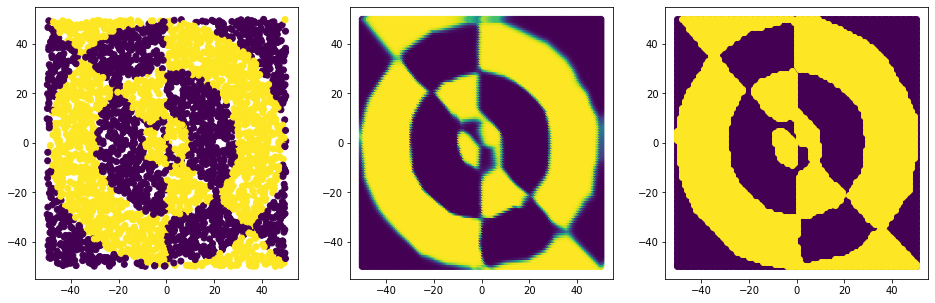

In [ ]:
# predict
pred_2 = best_model.predict(grid2_r)


# show
fig,AX = plt.subplots(1,figsize=(8,8))

#ax=AX[0]
#ax.scatter(x2[:,0],x2[:,1], c=y2)


#ax=AX[1]
#ax.scatter(grid2[:,0],grid2[:,1],c=pred_2[:,1])



W1=np.where(pred_2[:,1]>0.5)[0] 
AX.scatter(grid2[:,0],grid2[:,1],c="#440154")
AX.scatter(grid2[W1,0],grid2[W1,1],c="#fde725")

ax.set_title("Graphical Prediction with Best architecture", fontsize=16)

plt.savefig("Graph_Pred_Nlin2_BEST_Model", bbox_inches="tight")

plt.show()

## Confusion matrix

## Study rescaling of data
We **will** do this test only on the best model (with fine tuning, not by hand)

In [ ]:
# TYPES
    # 0 --> nothing, original data
    # 0.bis --> absolute maximum (requires scale)
    # 1 --> min max (requires xmax, xmin)
    # 2 --> normalization (requires xmean, xmax, xmin)
    # 3 --> standardization (requires xmean, xvar)
    # 4 --> robust scaling thorugh scikit-learn

# rescaling parameters
xmean_train = x[0:N_train].mean()
xvar_train = x[0:N_train].var()
rescaling_params = [{'res_type':0, 'scale':1},
                    {'res_type':0, 'scale':50},
                    {'res_type':1, 'xmin':-50, 'xmax':50},
                    {'res_type':2, 'xmean':0, 'xmin':-50, 'xmax':50},
                    {'res_type':3, 'xmean':xmean_train, 'xvar':xvar_train},
                    {'res_type':4}
                    ]


training_accuracies = []
test_accuracies = []
training_losses = []
test_losses = []

# perform training for each initialization
for params in rescaling_params:

    # rescale (again) the original training and test data
    x_train_n = Rescale(x[0:N_train], **params)
    x_valid_n = Rescale(x[N_train:], **params)

    fit_best_n = best_model.fit(x_train_n, y_train, 
                epochs = best_param['epochs'],
                batch_size=batch_size, 
                validation_data=(x_valid_n, y_valid), 
                verbose=0)


    # append new values of errors
    eval_train = best_model.evaluate(x_train_n, y_train_n, batch_size=batch_size, verbose=0)
    eval_test = best_model.evaluate(x_valid_n, y_valid_n, batch_size=batch_size, verbose=0)

    training_accuracies.append(eval_train[1])
    test_accuracies.append(eval_test[1])
    training_losses.append(eval_train[0])
    test_losses.append((eval_test[0]))


# collect data into a DataFrame
rescaling_df = pd.DataFrame(data={'Training inaccuracies': training_inaccuracies, 'Test inaccuracies': test_inaccuracies,
                                  'Training losses':training_losses, 'Test losses':test_losses},
                            index=['No rescaling', 'Abs max', 'Min max', 'Normalization', 'Standardization', 'Robust scaling'])

rescaling_df.round(4)
display(rescaling_df)

,Training inaccuracies,Test inaccuracies,Training losses,Test losses
No rescaling,0.537500,0.57500,61.820038,66.573952
Abs max,0.012500,0.00875,0.042844,0.036765
Min max,0.525937,0.50875,1.565840,1.559629
Normalization,0.337188,0.30875,1.364675,1.246621
Standardization,0.336563,0.36375,12.526904,13.824084
Robust scaling,0.017187,0.01625,0.045918,0.036089


##  Study of different initialization strategies
Again, we **will** do this test only on the best model (with fine tuning, not by hand). <br>
Suggested to use 4000 samples, no data augmentation.

In [ ]:
# change initialization of a compiled model
def change_initialization(model, weight_initializer, bias_initializer):
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            if hasattr(layer, 'bias_initializer'):
                old_weights, old_biases = layer.get_weights()
    
                new_weights = weight_initializer(shape=old_weights.shape)
                new_biases = bias_initializer(shape=old_biases.shape)
                
                layer.set_weights([new_weights, new_biases])


[ 0.13832122 -0.21845637 -1.1399876  -0.4241291  -0.24189492 -0.24153273
  0.03175073 -1.1246767  -0.41960245  0.07095606 -0.5190436  -0.22809388
 -0.29411042  0.2950378   0.1731463  -0.33880016 -0.01768944 -0.19636698
 -0.30321875  0.03052697 -0.14540526 -0.04921039 -0.01867567 -0.46860424
 -0.32269132 -0.1985244  -0.32190394  0.22350205 -0.2399774  -0.30155936
 -0.43511775  0.00235423 -1.0288513  -0.09017625 -0.1832348  -0.1567223
 -0.68157405 -0.18725725  0.36177245  0.06480305 -0.25000784  0.09205287
 -0.16387643 -0.3490285  -0.6902672  -0.2818476  -0.1738162  -0.06497078
 -0.23569593 -0.8033272 ]
[-0.10993435  0.06397562 -0.02256658 -0.0120691   0.10210418  0.00283092
  0.03083969 -0.01172883 -0.06427684  0.00903128  0.05756785 -0.0437386
 -0.05001745  0.00165808 -0.04621442 -0.02051681 -0.01480408  0.04249958
 -0.05078072  0.04319599 -0.03945257  0.07793814 -0.02940715  0.07467955
 -0.06142861 -0.04118824 -0.03350839 -0.00522913 -0.00803219  0.04962578
 -0.00905348  0.05143537 -0

In [ ]:
# on some initializars a seed can be used
inits=[
    initializers.Zeros(),
    initializers.RandomUniform(minval=0., maxval=1.),
    initializers.LecunUniform(),
    initializers.GlorotUniform(), # default one for Dense layers
    initializers.HeUniform()
]

training_accuracies = []
test_accuracies = []
training_losses = []
test_losses = []

for init in inits:
    change_initialization(best_model_by_hand, init, init) # same initialization of weights and biases

    fit_init = best_model.fit(x2_train, y2_train, 
                epochs = best_param['epochs'],
                batch_size=batch_size, 
                validation_data=(x2_valid, y2_valid), 
                verbose=0)

    # append new values of errors
    eval_train = best_model(x2_train, y2_train, batch_size=batch_size, verbose=0)
    eval_test = best_model(x2_valid, y2_valid, batch_size=batch_size, verbose=0)

    training_accuracies.append(eval_train[1]
    test_accuracies.append(eval_test[1])
    training_losses.append(eval_train[0])
    test_losses.append((eval_test[0]))



# collect data into a DataFrame
initialization_df = pd.DataFrame(data={'Training inaccuracies': training_inaccuracies, 'Test inaccuracies': test_inaccuracies,
                                       'Training losses':training_losses, 'Test losses':test_losses},
                                 index=['All-zeros', 'Random', 'LeCun', 'Glorot', 'He'])

initialization_df.round(4)
display(initialization_df)


,Training inaccuracies,Test inaccuracies,Training losses,Test losses
All-zeros,0.462500,0.42500,0.690333,0.684586
Random,0.009375,0.00375,0.018607,0.012947
LeCun,0.005313,0.00125,0.013370,0.008008
Glorot,0.004687,0.00500,0.012401,0.011243
He,0.009375,0.00500,0.017038,0.014200


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68aafe1b-040f-4657-bf91-52c6a793f99c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>